In [1]:
pip install yfinance pandas numpy


In [24]:
def get_clean_close(tickers, period="1y", interval="1d"):
    close_data = []

    for ticker in tickers:
        try:
            data = yf.download(ticker, period=period, interval=interval, progress=False)
            if data.empty:
                print(f"❌ No data for {ticker}")
                continue

            if "Close" in data.columns:
                df = data[["Close"]].copy()
                df.rename(columns={"Close": ticker}, inplace=True)
                close_data.append(df)
                print(f"✅ Got data for {ticker}")
            else:
                print(f"⚠️ 'Close' column missing for {ticker}")
        except Exception as e:
            print(f"❌ Error fetching {ticker}: {e}")

    if not close_data:
        raise ValueError("❌ No valid stock data fetched.")

    # ✅ Combine all Series on the date index
    combined_df = pd.concat(close_data, axis=1)
    combined_df.index.name = "Date"
    return combined_df



In [25]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
df = get_clean_close(tickers)
df.tail()


✅ Got data for AAPL
✅ Got data for MSFT
✅ Got data for GOOGL
✅ Got data for TSLA


Price,AAPL,MSFT,GOOGL,TSLA
Ticker,AAPL,MSFT,GOOGL,TSLA
Date,,,,
2025-05-14,212.330002,452.109985,165.369995,347.679993
2025-05-15,211.449997,453.130005,163.960007,342.820007
2025-05-16,211.259995,454.269989,166.190002,349.980011
2025-05-19,208.779999,458.869995,166.539993,342.089996
2025-05-20,206.860001,458.170013,163.979996,343.820007


In [26]:
def get_risk_weights(risk_level):
    # Define sample weights for 4 stocks (must sum to 1)
    if risk_level == "Low":
        return {"AAPL": 0.35, "MSFT": 0.40, "GOOGL": 0.20, "TSLA": 0.05}
    elif risk_level == "Medium":
        return {"AAPL": 0.30, "MSFT": 0.25, "GOOGL": 0.25, "TSLA": 0.20}
    elif risk_level == "High":
        return {"AAPL": 0.20, "MSFT": 0.15, "GOOGL": 0.25, "TSLA": 0.40}
    else:
        raise ValueError("Risk level must be one of: Low, Medium, High")


In [27]:
# Ask user
risk = input("Enter your risk appetite (Low / Medium / High): ")

# Get portfolio weights
weights = get_risk_weights(risk.title())  # Capitalize first letter
print("📊 Portfolio Allocation Weights:", weights)


Enter your risk appetite (Low / Medium / High): medium
📊 Portfolio Allocation Weights: {'AAPL': 0.3, 'MSFT': 0.25, 'GOOGL': 0.25, 'TSLA': 0.2}


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Calculate daily returns
daily_returns = df.pct_change().dropna()

# STEP 2: Convert weights to numpy array
tickers = list(weights.keys())
weight_array = np.array([weights[t] for t in tickers])

# STEP 3: Portfolio daily returns
portfolio_returns = daily_returns[tickers] @ weight_array  # matrix multiplication

# STEP 4: Portfolio metrics
mean_daily_return = portfolio_returns.mean()
volatility = portfolio_returns.std()
cumulative_growth = (1 + portfolio_returns).cumprod()

# STEP 5: Display metrics
print(f"📈 Expected Daily Return: {mean_daily_return:.4f}")
print(f"📉 Daily Volatility (Risk): {volatility:.4f}")
print(f"📊 Expected Annual Return: {mean_daily_return * 252:.2%}")
print(f"⚠️ Annual Volatility: {volatility * np.sqrt(252):.2%}")


📈 Expected Daily Return: 0.0009
📉 Daily Volatility (Risk): 0.0199
📊 Expected Annual Return: 23.44%
⚠️ Annual Volatility: 31.66%


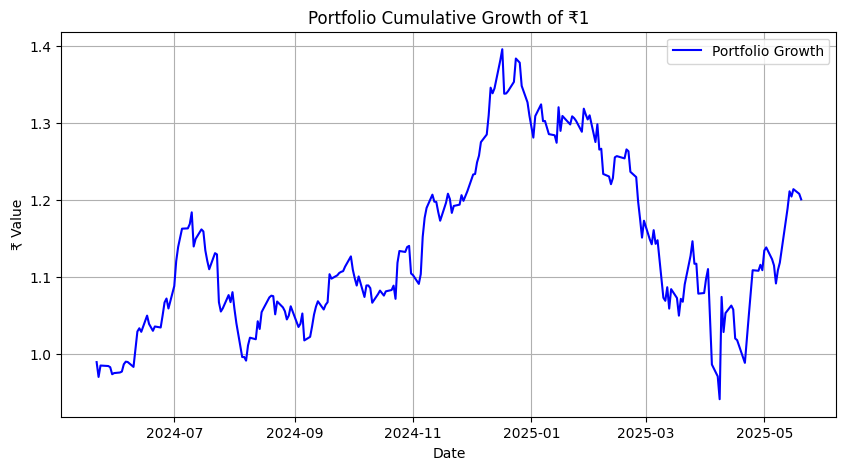

In [29]:
plt.figure(figsize=(10,5))
plt.plot(cumulative_growth, label='Portfolio Growth', color='blue')
plt.title("Portfolio Cumulative Growth of ₹1")
plt.ylabel("₹ Value")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.show()


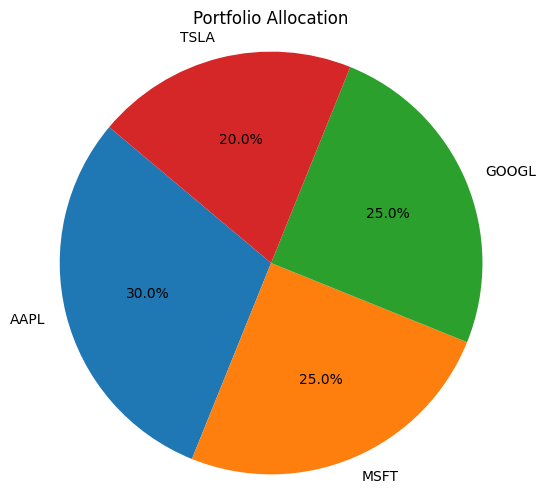

In [30]:
plt.figure(figsize=(6,6))
plt.pie(weight_array, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation")
plt.axis('equal')
plt.show()


In [31]:
def generate_recommendation(risk_level, annual_return, annual_volatility):
    advice = ""

    if risk_level == "Low":
        if annual_volatility > 0.20:
            advice += "⚠️ Your portfolio is a bit risky for a low-risk profile.\n"
            advice += "🔄 Consider reducing exposure to high-volatility stocks like TSLA.\n"
        else:
            advice += "✅ Your portfolio aligns well with a conservative strategy.\n"
            advice += "💡 Consider adding bonds or dividend ETFs for more stability.\n"

    elif risk_level == "Medium":
        advice += "🟢 Balanced portfolio.\n"
        if annual_return > 0.12:
            advice += "📈 Expected return is strong — maintain current strategy.\n"
        else:
            advice += "🔍 Consider increasing exposure to growth stocks or ETFs.\n"

    elif risk_level == "High":
        if annual_volatility < 0.25:
            advice += "📉 Portfolio may be too conservative for a high-risk appetite.\n"
            advice += "💹 Consider higher allocation to high-growth sectors like tech or crypto ETFs.\n"
        else:
            advice += "⚡ Good match for aggressive strategy.\n"
            advice += "🎯 Monitor regularly to capture upside & manage downside risk.\n"

    return advice


In [32]:
risk_level = risk.title()  # From earlier input
annual_return = mean_daily_return * 252
annual_volatility = volatility * np.sqrt(252)

recommendation = generate_recommendation(risk_level, annual_return, annual_volatility)
print("\n📋 Investment Advisor Recommendation:\n")
print(recommendation)



📋 Investment Advisor Recommendation:

🟢 Balanced portfolio.
📈 Expected return is strong — maintain current strategy.



In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Number of portfolios
n_portfolios = 10000
all_weights = np.zeros((n_portfolios, len(tickers)))
ret_arr = np.zeros(n_portfolios)
vol_arr = np.zeros(n_portfolios)
sharpe_arr = np.zeros(n_portfolios)

np.random.seed(42)

for i in range(n_portfolios):
    # Random weights
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Save weights
    all_weights[i, :] = weights

    # Expected return
    # Corrected variable name from 'returns' to 'daily_returns'
    ret_arr[i] = np.sum(daily_returns.mean() * weights * 252)  # Annualized

    # Expected volatility
    # Corrected variable name from 'returns' to 'daily_returns'
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))

    # Sharpe Ratio (risk-free rate = 0)
    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

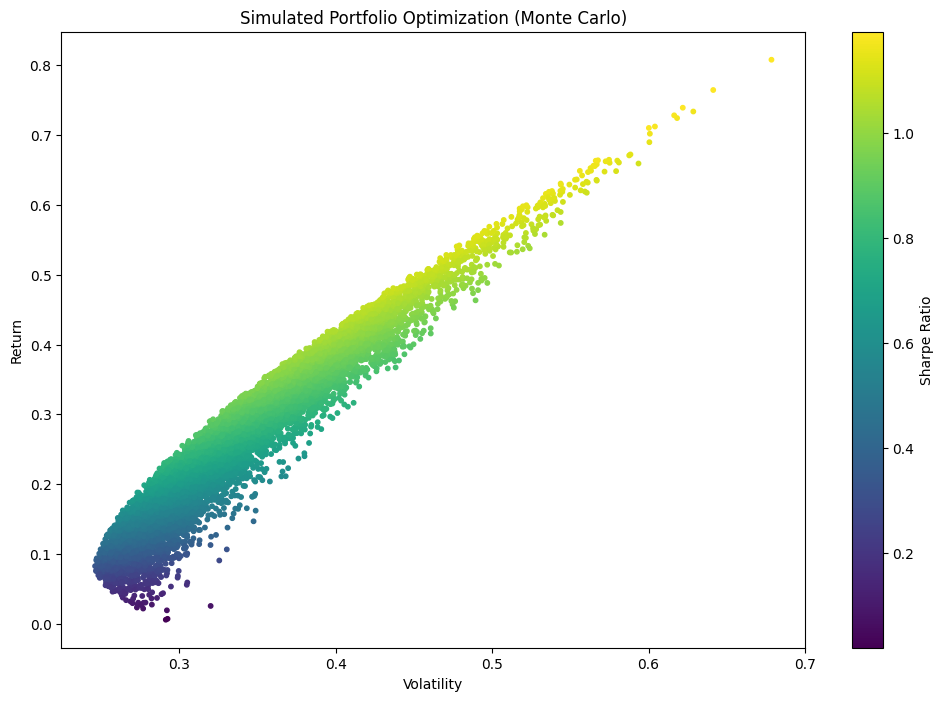

In [35]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Simulated Portfolio Optimization (Monte Carlo)')
plt.show()


In [36]:
# Max Sharpe Ratio Portfolio
max_sharpe_idx = sharpe_arr.argmax()
optimal_weights = all_weights[max_sharpe_idx]

print("Optimal Portfolio Allocation:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]*100:.2f}%")

print(f"\nExpected Annual Return: {ret_arr[max_sharpe_idx]*100:.2f}%")
print(f"Annual Volatility: {vol_arr[max_sharpe_idx]*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_arr[max_sharpe_idx]:.2f}")


Optimal Portfolio Allocation:
AAPL: 4.45%
MSFT: 9.72%
GOOGL: 0.34%
TSLA: 85.49%

Expected Annual Return: 76.47%
Annual Volatility: 64.14%
Sharpe Ratio: 1.19


In [39]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
start_date = '2019-01-01'
end_date = '2024-12-31'

# Download all stock data
raw_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

# Extract 'Adj Close' properly
adj_close = pd.DataFrame()

for ticker in tickers:
    if ('Adj Close' in raw_data[ticker].columns):
        adj_close[ticker] = raw_data[ticker]['Adj Close']
    else:
        print(f"⚠️ 'Adj Close' not found for {ticker}")

# Drop missing values
adj_close.dropna(inplace=True)

# Show the cleaned DataFrame
adj_close.head()


[*********************100%***********************]  4 of 4 completed


,AAPL,MSFT,GOOGL,TSLA
Date,,,,
2019-01-02,37.617855,94.945511,52.483086,20.674667
2019-01-03,33.870834,91.452652,51.029530,20.024000
2019-01-04,35.316761,95.706047,53.647015,21.179333
2019-01-07,35.238155,95.828117,53.540028,22.330667
2019-01-08,35.909885,96.522934,54.010277,22.356667


In [40]:
data = adj_close


In [41]:
returns = data.pct_change().dropna()
returns.tail()


,AAPL,MSFT,GOOGL,TSLA
Date,,,,
2024-12-23,0.003065,-0.003092,0.016823,0.022657
2024-12-24,0.011478,0.009374,0.007604,0.073572
2024-12-26,0.003176,-0.002777,-0.002601,-0.017630
2024-12-27,-0.013242,-0.017302,-0.014519,-0.049479
2024-12-30,-0.013263,-0.013240,-0.007885,-0.033012


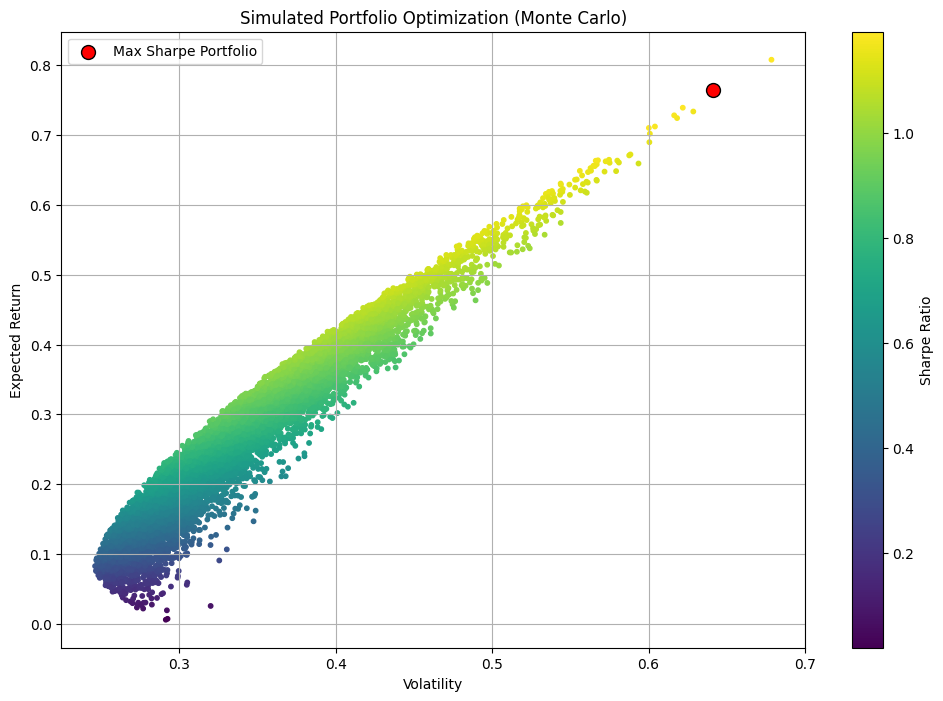

In [42]:
# Find the optimal Sharpe Ratio
max_sharpe_idx = sharpe_arr.argmax()
max_sharpe_ret = ret_arr[max_sharpe_idx]
max_sharpe_vol = vol_arr[max_sharpe_idx]

# Enhanced plot
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')

# Highlight optimal portfolio
plt.scatter(max_sharpe_vol, max_sharpe_ret, c='red', s=100, edgecolors='black', label='Max Sharpe Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Simulated Portfolio Optimization (Monte Carlo)')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
optimal_weights = all_weights[max_sharpe_idx]
portfolio_weights = dict(zip(tickers, np.round(optimal_weights, 3)))
portfolio_weights


{'AAPL': np.float64(0.045),
 'MSFT': np.float64(0.097),
 'GOOGL': np.float64(0.003),
 'TSLA': np.float64(0.855)}

In [44]:
!pip install prophet --quiet


In [45]:
from prophet import Prophet

# Prepare AAPL data
aapl_df = data['AAPL'].reset_index()
aapl_df = aapl_df.rename(columns={'Date': 'ds', 'AAPL': 'y'})

# View sample
aapl_df.tail()


,ds,y
1504,2024-12-23,254.655716
1505,2024-12-24,257.578674
1506,2024-12-26,258.396667
1507,2024-12-27,254.974930
1508,2024-12-30,251.593079


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zos55z_/ly6x4hmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zos55z_/ailk95i3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81255', 'data', 'file=/tmp/tmp8zos55z_/ly6x4hmw.json', 'init=/tmp/tmp8zos55z_/ailk95i3.json', 'output', 'file=/tmp/tmp8zos55z_/prophet_model6qsmhvwi/prophet_model-20250521061428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


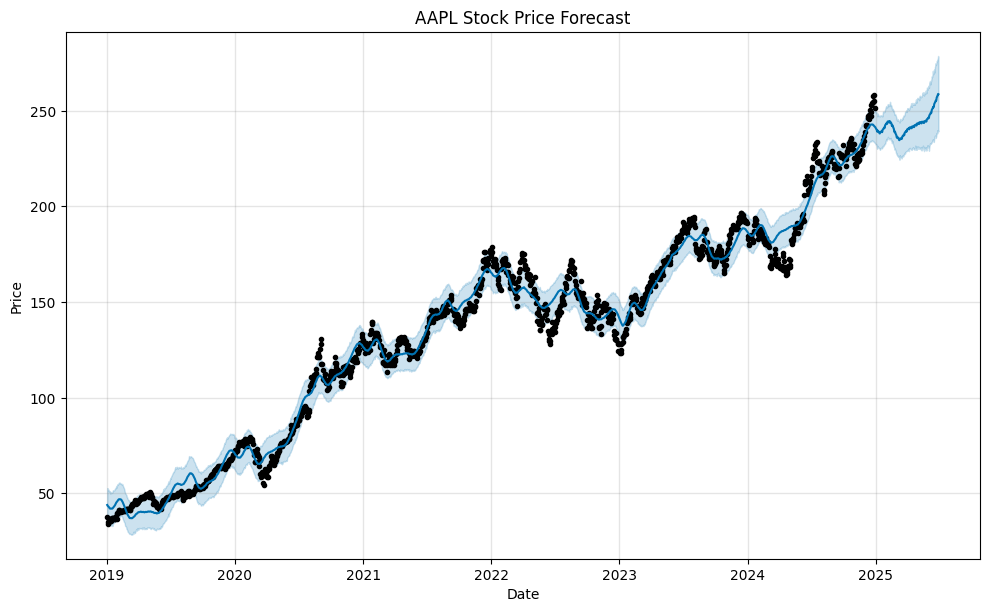

In [46]:
model = Prophet()
model.fit(aapl_df)

# Forecast for next 6 months
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title("AAPL Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [47]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1684,2025-06-24,257.250911,237.927758,275.940626
1685,2025-06-25,257.705349,239.823100,276.808222
1686,2025-06-26,258.157414,238.665978,276.890603
1687,2025-06-27,258.779438,239.730909,278.650394
1688,2025-06-28,258.638859,239.243799,277.811010
